In [1]:
import pandas as pd
import numpy as np

# Set random seed for reproducibility
np.random.seed(42)


In [2]:
import sys
import glob, os

# remove warnings
import warnings
warnings.filterwarnings('ignore')

from pyprojroot import here

# Add the project root to sys.path
sys.path.append(str(here()))

from hspc.config import get_config
config = get_config()

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split,StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models

In [4]:
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.utils.class_weight import compute_class_weight
from collections import Counter

from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.model_selection import cross_val_score

In [5]:

from tensorflow import keras
import keras_tuner as kt
from keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
import numpy as np

In [6]:
import random
def set_seed(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    
set_seed(42)

In [7]:
from tabpfn import TabPFNClassifier as tbp
import shapiq

In [8]:
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)

# Load Data
Here we will load the data from IU and CU (Piccirillo)

In [23]:
dataset = pd.read_csv(here() / config.data_interim / 'd_p_h_combined_unnormalized.csv')
dataset

,Gender,Age,WBC,Hgb,Hct,Platelet Ct,Neut Pct,Lymphocyte Abs,Mono Pct,Lymph Pct,Eos Pct,Mono Abs,Neut Abs,Eos Abs,Day 1 CD34 Absolute per uL,Count,lab
0,1,39,11.2,14.6,43.5,328.0,64.5,2.9,7.4,25.5,1.9,0.8,7.2,0.2,100.0,1,Dipersio
1,0,57,6.5,14.5,42.9,280.0,48.1,2.7,5.9,41.1,4.0,0.4,3.1,0.3,71.0,1,Dipersio
2,1,43,4.4,15.0,43.9,299.0,58.0,1.3,10.0,28.7,2.7,0.4,2.6,0.1,87.0,1,Dipersio
3,0,50,6.7,14.2,40.6,243.0,56.4,2.0,7.7,29.8,4.8,0.5,3.8,0.3,27.0,0,Dipersio
4,0,32,9.8,13.3,39.2,373.0,65.1,2.6,6.4,26.5,1.7,0.6,6.4,0.2,31.0,0,Dipersio
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1155,1,23,31.3,13.5,39.4,257.0,76.0,2.8,8.0,9.0,1.0,2.5,23.8,0.3,58.0,1,hurwitz
1156,1,56,37.0,15.4,44.9,233.0,77.0,4.4,7.0,12.0,1.0,2.6,28.5,0.4,59.0,1,hurwitz
1157,0,25,51.9,13.8,40.7,265.0,64.0,7.3,9.0,14.0,1.0,4.7,33.2,0.5,56.0,1,hurwitz
1158,1,22,51.0,14.6,42.9,250.0,89.0,4.1,2.0,8.0,1.0,1.0,45.3,0.5,174.0,1,hurwitz


In [24]:
# add labtype column and set it to 0 if lab is 'Dipersio' else 1
dataset['labtype'] = dataset['lab'].apply(lambda x: 0 if x == 'Dipersio' else 1)
dataset = dataset.drop(columns=['lab'])

# move labtype to the 3rd column
cols = dataset.columns.tolist()
cols.insert(2, cols.pop(cols.index('labtype')))
dataset = dataset[cols]



In [25]:
dataset.drop(columns=['Day 1 CD34 Absolute per uL'], inplace=True)

In [26]:
# remove all rows containing N/A and map samples to respective classes
dataset = dataset.dropna(axis=0, how='any')

In [27]:
# apply linear normalization
df_temp = dataset.iloc[:,:-1]
dataset.iloc[:,:-1] = (df_temp - df_temp.min()) / (df_temp.max() - df_temp.min())

In [28]:
# oversample the bad mobilizers to balance the dataset with SMOTE
X = dataset.iloc[:,:-1]
y = dataset.iloc[:,-1]
oversample = SMOTE(random_state=42)
X, y = oversample.fit_resample(X, y)


In [30]:
# convert y in to binary classes
y = (y > 0).astype(int)

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.2, random_state=42)

In [32]:
clf = tbp()
clf.fit(X_train, y_train)

TabPFNClassifier()

In [ ]:
# # save the model as a pickle file
# import pickle
# with open(here() / config.model_dl / 'tabpfn_model_integ.pkl', 'wb') as f:
#     pickle.dump(clf, f)

ROC AUC: 0.9683040935672516


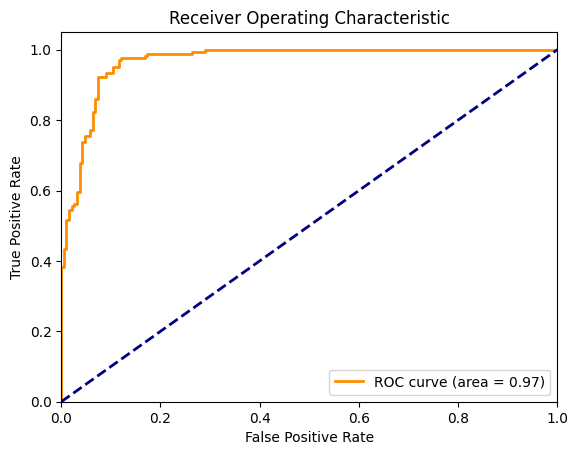

In [33]:
prediction_prob = clf.predict_proba(X_test)
print('ROC AUC:', roc_auc_score(y_test, prediction_prob[:,1]))

# plot ROC curve
fpr, tpr, _ = roc_curve(y_test, prediction_prob[:,1])
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig(here() / config.plots / 'model_results' / 'tabpfn_domain_all' / 'roc_curve.png', dpi=300, bbox_inches='tight')
plt.savefig(here() / config.plots / 'model_results' / 'tabpfn_domain_all' / 'roc_curve.pdf', dpi=300, bbox_inches='tight')
plt.show()

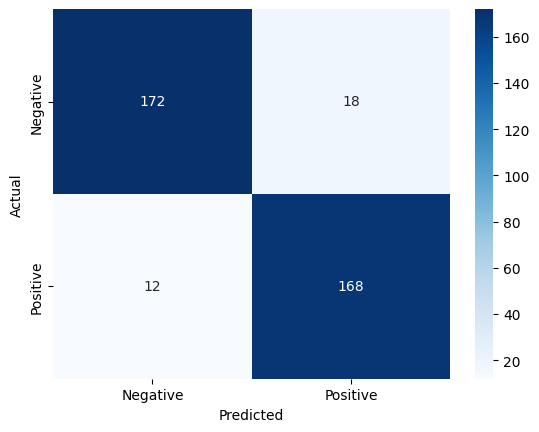

In [34]:
# plot confusion matrix
y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig(here() / config.plots / 'model_results' / 'tabpfn_domain_all' / 'confusion_matrix.png', dpi=500, bbox_inches='tight')
plt.savefig(here() / config.plots / 'model_results' / 'tabpfn_domain_all' / 'confusion_matrix.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [35]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.91      0.92       190
           1       0.90      0.93      0.92       180

    accuracy                           0.92       370
   macro avg       0.92      0.92      0.92       370
weighted avg       0.92      0.92      0.92       370



In [36]:
# print the prediction probabilities of the first 10 samples
print("Prediction probabilities of the first 10 samples:")
for i in range(20):
    print(f"Sample {i+1}: {prediction_prob[i]}")
# print the actual labels of the first 10 samples
print("Actual labels of the first 10 samples:")
for i in range(20):
    print(f"Sample {i+1}: {y_test[i]}")
# print the predicted labels of the first 10 samples
print("Predicted labels of the first 10 samples:")
for i in range(20):
    print(f"Sample {i+1}: {y_pred[i]}")


Prediction probabilities of the first 10 samples:
Sample 1: [0.7980051  0.20199487]
Sample 2: [0.9977384  0.00226161]
Sample 3: [0.994373   0.00562701]
Sample 4: [0.9943679  0.00563207]
Sample 5: [0.38530582 0.6146942 ]
Sample 6: [0.05548183 0.94451815]
Sample 7: [0.9981001  0.00189992]
Sample 8: [0.9988121  0.00118794]
Sample 9: [0.9012477  0.09875232]
Sample 10: [0.20167415 0.7983258 ]
Sample 11: [0.8870704  0.11292964]
Sample 12: [0.22953455 0.77046543]
Sample 13: [0.82662773 0.17337224]
Sample 14: [0.15990818 0.8400918 ]
Sample 15: [0.00567418 0.9943258 ]
Sample 16: [0.07232025 0.9276797 ]
Sample 17: [0.2995874  0.70041263]
Sample 18: [0.99117386 0.00882613]
Sample 19: [0.98370653 0.01629345]
Sample 20: [9.9986404e-01 1.3598640e-04]
Actual labels of the first 10 samples:
Sample 1: 0
Sample 2: 0
Sample 3: 0
Sample 4: 0
Sample 5: 1
Sample 6: 1
Sample 7: 0
Sample 8: 0
Sample 9: 0
Sample 10: 1
Sample 11: 0
Sample 12: 1
Sample 13: 0
Sample 14: 1
Sample 15: 1
Sample 16: 1
Sample 17: 0
Sa